In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Import Libraries

In [7]:
import warnings
warnings.filterwarnings('ignore')
import math
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Dense, Activation
import nltk
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from sklearn import preprocessing, metrics
from sklearn.preprocessing import MinMaxScaler

# 2. Upload Datasets For Stock Data And News Headlines

In [ ]:
stock_price = pd.read_csv('/content/drive/MyDrive/BSESN.csv')
stock_headlines = pd.read_csv('/content/drive/MyDrive/india-news-headlines.csv')

# 3. Data Cleaning

In [ ]:
stock_price.head()

Date         Open         High  ...        Close    Adj Close  Volume
0  2001-01-02  3953.219971  4028.570068  ...  4018.879883  4018.879883     0.0
1  2001-01-03  3977.580078  4067.659912  ...  4060.020020  4060.020020     0.0
2  2001-01-04  4180.970215  4180.970215  ...  4115.370117  4115.370117     0.0
3  2001-01-05  4116.339844  4195.009766  ...  4183.729980  4183.729980     0.0
4  2001-01-08  4164.759766  4206.720215  ...  4120.430176  4120.430176     0.0

[5 rows x 7 columns]

In [ ]:
stock_headlines.head()

publish_date  ...                                      headline_text
0      20010102  ...  Status quo will not be disturbed at Ayodhya; s...
1      20010102  ...                Fissures in Hurriyat over Pak visit
2      20010102  ...              America's unwanted heading for India?
3      20010102  ...                 For bigwigs; it is destination Goa
4      20010102  ...               Extra buses to clear tourist traffic

[5 rows x 3 columns]

In [ ]:
# displaying number of records in both stock_price and stock_headlines datasets
len(stock_price), len(stock_headlines)

(5043, 3424067)

In [ ]:
# checking for null values in both the datasets
stock_price = stock_price.dropna()
stock_headlines = stock_headlines.dropna()
stock_price.isna().any(), stock_headlines.isna().any()

(Date         False
 Open         False
 High         False
 Low          False
 Close        False
 Adj Close    False
 Volume       False
 dtype: bool, publish_date         False
 headline_category    False
 headline_text        False
 dtype: bool)

# 3.1. Numerical Stock Data

In [ ]:
# dropping duplicates
stock_price = stock_price.drop_duplicates()

# coverting the datatype of column 'Date' from type object to type 'datetime'
stock_price['Date'] = pd.to_datetime(stock_price['Date']).dt.normalize()

# filtering the important columns required
stock_price = stock_price.filter(['Date', 'Close', 'Open', 'High', 'Low', 'Volume'])

# setting column 'Date' as the index column
stock_price.set_index('Date', inplace= True)

# sorting the data according to the index i.e 'Date'
stock_price = stock_price.sort_index(ascending=True, axis=0)
stock_price

Close          Open          High           Low   Volume
Date                                                                       
2001-01-02   4018.879883   3953.219971   4028.570068   3929.370117      0.0
2001-01-03   4060.020020   3977.580078   4067.659912   3977.580078      0.0
2001-01-04   4115.370117   4180.970215   4180.970215   4109.549805      0.0
2001-01-05   4183.729980   4116.339844   4195.009766   4115.350098      0.0
2001-01-08   4120.430176   4164.759766   4206.720215   4101.529785      0.0
...                  ...           ...           ...           ...      ...
2021-03-01  49849.839844  49747.710938  50058.421875  49440.460938  18400.0
2021-03-02  50296.890625  50258.089844  50439.820313  49807.121094  17500.0
2021-03-03  51444.648438  50738.210938  51539.890625  50512.839844  15800.0
2021-03-04  50846.078125  50812.140625  51256.550781  50539.921875  21800.0
2021-03-05  50405.320313  50517.359375  50886.191406  50160.539063  19200.0

[4966 rows x 5 columns]

# 3.2. Textual News Headlines Data

In [ ]:
# dropping duplicates
stock_headlines = stock_headlines.drop_duplicates()

# coverting the datatype of column 'Date' from type string to type 'datetime'
stock_headlines['publish_date'] = stock_headlines['publish_date'].astype(str)
stock_headlines['publish_date'] = stock_headlines['publish_date'].apply(lambda x: x[0:4]+'-'+x[4:6]+'-'+x[6:8])
stock_headlines['publish_date'] = pd.to_datetime(stock_headlines['publish_date']).dt.normalize()

# filtering the important columns required
stock_headlines = stock_headlines.filter(['publish_date', 'headline_text'])

# grouping the news headlines according to 'Date'
stock_headlines = stock_headlines.groupby(['publish_date'])['headline_text'].apply(lambda x: ','.join(x)).reset_index()

# setting column 'Date' as the index column
stock_headlines.set_index('publish_date', inplace= True)

# sorting the data according to the index i.e 'Date'
stock_headlines = stock_headlines.sort_index(ascending=True, axis=0)
stock_headlines

headline_text
publish_date                                                   
2001-01-02    Status quo will not be disturbed at Ayodhya; s...
2001-01-03    Powerless north India gropes in the dark,Think...
2001-01-04    The string that pulled Stephen Hawking to Indi...
2001-01-05    Light combat craft takes India into club class...
2001-01-06    Light combat craft takes India into club class...
...                                                         ...
2020-12-27    #BigInterview! Dhritiman Chatterjee: Nobody da...
2020-12-28    Horoscope Today; 28 December 2020: Check astro...
2020-12-29    Man recovers charred remains of 'thief' from h...
2020-12-30    Numerology Readings 30 December 2020: Predicti...
2020-12-31    Horoscope Today; 31 December 2020: Check astro...

[7262 rows x 1 columns]

# 4. Combine Stock Data

In [ ]:
# concatenating the datasets stock_price and stock_headlines
stock_data = pd.concat([stock_price, stock_headlines], axis=1)

# dropping the null values if any
stock_data.dropna(axis=0, inplace=True)

# displaying the combined stock_data
stock_data


Close  ...                                      headline_text
2001-01-02   4018.879883  ...  Status quo will not be disturbed at Ayodhya; s...
2001-01-03   4060.020020  ...  Powerless north India gropes in the dark,Think...
2001-01-04   4115.370117  ...  The string that pulled Stephen Hawking to Indi...
2001-01-05   4183.729980  ...  Light combat craft takes India into club class...
2001-01-08   4120.430176  ...  Sangh Parivar; Babri panel up the ante,Frontru...
...                  ...  ...                                                ...
2020-12-24  46973.539063  ...  How to set the mood for sex during cold winter...
2020-12-28  47353.750000  ...  Horoscope Today; 28 December 2020: Check astro...
2020-12-29  47613.078125  ...  Man recovers charred remains of 'thief' from h...
2020-12-30  47746.218750  ...  Numerology Readings 30 December 2020: Predicti...
2020-12-31  47751.328125  ...  Horoscope Today; 31 December 2020: Check astro...

[4893 rows x 6 columns]

In [ ]:
#alternate way is to use merge funtion and inner join operation 
pd.merge(stock_price, stock_headlines, left_index=True, right_index=True, how='inner')

Close  ...                                      headline_text
2001-01-02   4018.879883  ...  Status quo will not be disturbed at Ayodhya; s...
2001-01-03   4060.020020  ...  Powerless north India gropes in the dark,Think...
2001-01-04   4115.370117  ...  The string that pulled Stephen Hawking to Indi...
2001-01-05   4183.729980  ...  Light combat craft takes India into club class...
2001-01-08   4120.430176  ...  Sangh Parivar; Babri panel up the ante,Frontru...
...                  ...  ...                                                ...
2020-12-24  46973.539063  ...  How to set the mood for sex during cold winter...
2020-12-28  47353.750000  ...  Horoscope Today; 28 December 2020: Check astro...
2020-12-29  47613.078125  ...  Man recovers charred remains of 'thief' from h...
2020-12-30  47746.218750  ...  Numerology Readings 30 December 2020: Predicti...
2020-12-31  47751.328125  ...  Horoscope Today; 31 December 2020: Check astro...

[4893 rows x 6 columns]

# 5. Sentiment Analysis

In [ ]:
# adding empty sentiment columns to stock_data for later calculation
stock_data['compound'] = ''
stock_data['negative'] = ''
stock_data['neutral'] = ''
stock_data['positive'] = ''
stock_data['subjectivity'] = ''
stock_data.head()

Close         Open         High  ...  neutral  positive subjectivity
2001-01-02  4018.879883  3953.219971  4028.570068  ...                                
2001-01-03  4060.020020  3977.580078  4067.659912  ...                                
2001-01-04  4115.370117  4180.970215  4180.970215  ...                                
2001-01-05  4183.729980  4116.339844  4195.009766  ...                                
2001-01-08  4120.430176  4164.759766  4206.720215  ...                                

[5 rows x 11 columns]

In [ ]:
headlines = []
for row in range(0, len(stock_headlines.index)):
    headlines.append(''.join( str(x)for x in stock_headlines.iloc[row, 0]))
headlines

["Status quo will not be disturbed at Ayodhya; says Vajpayee,Fissures in Hurriyat over Pak visit,America's unwanted heading for India?,For bigwigs; it is destination Goa,Extra buses to clear tourist traffic,Dilute the power of transfers; says Riberio,Focus shifts to teaching of Hindi,IT will become compulsory in schools,Move to stop freedom fighters' pension flayed,Gilani claims he applied for passport 2 years ago,Parivar dismisses PM's warning,India; Pak exchange lists of N-plants,Will Qureshi's return really help the govt?,PM's tacit message: Put Ram tample on hold,Text of the Prime Minister's article,NCW to focus on violence against women,BBC's reality TV will focus on AIIMS,Jaitley firm on legal reforms,Hoshangabad farmers have enough water,BJP jumps into rail track conversion issue,State may take AP to court over Krishna,This official has sued the briber,Park turns temple compound as residents watch,Moves afoot to evict squatters in Urban dist,Mafia calls the shots in Gandhinagar 

In [ ]:
clean_headlines = []
for i in range(0, len(headlines)):
    clean_headlines.append(re.sub("b[(')]", '', headlines[i]))
    clean_headlines[i] = re.sub('b[(")]','',clean_headlines[i])
    clean_headlines[i] = re.sub("\'",'',clean_headlines[i])

In [ ]:
stock_headlines['headline_text'] = clean_headlines

In [ ]:
stock_data = pd.merge(stock_price, stock_headlines, left_index=True, right_index=True, how='inner')

In [ ]:
 import nltk
 nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
from textblob import TextBlob
def getsubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

# instantiating the Sentiment Analyzer
sid = SentimentIntensityAnalyzer()

# calculating sentiment scores
stock_data['compound'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['compound'])
stock_data['negative'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['neg'])
stock_data['neutral'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['neu'])
stock_data['positive'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['pos'])
stock_data['subjectivity'] = stock_data ['headline_text'].apply(getsubjectivity)
# displaying the stock data
stock_data.head()

Close         Open  ...  positive  subjectivity
2001-01-02  4018.879883  3953.219971  ...     0.064      0.240909
2001-01-03  4060.020020  3977.580078  ...     0.098      0.458333
2001-01-04  4115.370117  4180.970215  ...     0.080      0.508531
2001-01-05  4183.729980  4116.339844  ...     0.149      0.462652
2001-01-08  4120.430176  4164.759766  ...     0.026      0.316351

[5 rows x 11 columns]

In [ ]:
stock_data.head(1)

Close         Open  ...  positive  subjectivity
2001-01-02  4018.879883  3953.219971  ...     0.064      0.240909

[1 rows x 11 columns]

In [ ]:
# dropping the 'headline_text' which is unwanted now
stock_data.drop(['headline_text'], inplace=True, axis=1)

# rearranging the columns of the whole stock_data
stock_data = stock_data[['Close',	'Open',	'High',	'Low',	'Volume',	'compound',	'negative',	'neutral',	'positive',	'subjectivity']]

# set the index name
stock_data.index.name = 'Date'

# displaying the final stock_data
stock_data.head()

Close         Open  ...  positive  subjectivity
Date                                  ...                        
2001-01-02  4018.879883  3953.219971  ...     0.064      0.240909
2001-01-03  4060.020020  3977.580078  ...     0.098      0.458333
2001-01-04  4115.370117  4180.970215  ...     0.080      0.508531
2001-01-05  4183.729980  4116.339844  ...     0.149      0.462652
2001-01-08  4120.430176  4164.759766  ...     0.026      0.316351

[5 rows x 10 columns]

In [ ]:
# writing the prepared stock_data to disk
stock_data.to_csv('/content/drive/MyDrive/Final_data.csv')

In [8]:
stock_data = pd.read_csv('/content/drive/MyDrive/Final_data.csv')

In [9]:
stock_data.head(1)

Date        Close         Open  ...  neutral  positive  subjectivity
0  2001-01-02  4018.879883  3953.219971  ...    0.817     0.064      0.240909

[1 rows x 11 columns]

In [10]:
stock_data.set_index('Date', inplace= True)
stock_data.head(1)

Close         Open  ...  positive  subjectivity
Date                                  ...                        
2001-01-02  4018.879883  3953.219971  ...     0.064      0.240909

[1 rows x 10 columns]

# 6. Exploratory Data Analysis

In [11]:
# displaying the shape i.e. number of rows and columns of stock_data
stock_data.shape

(4893, 10)

In [12]:
# checking for null values
stock_data.isna().any()

Close           False
Open            False
High            False
Low             False
Volume          False
compound        False
negative        False
neutral         False
positive        False
subjectivity    False
dtype: bool

In [13]:
# displaying stock_data statistics
stock_data.describe(include='all')

Close          Open  ...     positive  subjectivity
count   4893.000000   4893.000000  ...  4893.000000   4893.000000
mean   18685.761055  18706.141903  ...     0.086088      0.398818
std    11233.725489  11250.819220  ...     0.020813      0.041638
min     2600.120117   2621.889893  ...     0.000000      0.000000
25%     8929.440430   8939.379883  ...     0.075000      0.378931
50%    17618.349609  17650.820313  ...     0.086000      0.398204
75%    27288.169922  27316.429688  ...     0.096000      0.418873
max    47751.328125  47789.031250  ...     0.608000      1.000000

[8 rows x 10 columns]

In [14]:
# displaying stock_data information
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4893 entries, 2001-01-02 to 2020-12-31
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Close         4893 non-null   float64
 1   Open          4893 non-null   float64
 2   High          4893 non-null   float64
 3   Low           4893 non-null   float64
 4   Volume        4893 non-null   float64
 5   compound      4893 non-null   float64
 6   negative      4893 non-null   float64
 7   neutral       4893 non-null   float64
 8   positive      4893 non-null   float64
 9   subjectivity  4893 non-null   float64
dtypes: float64(10)
memory usage: 420.5+ KB


Text(0, 0.5, 'Close Price ($)')

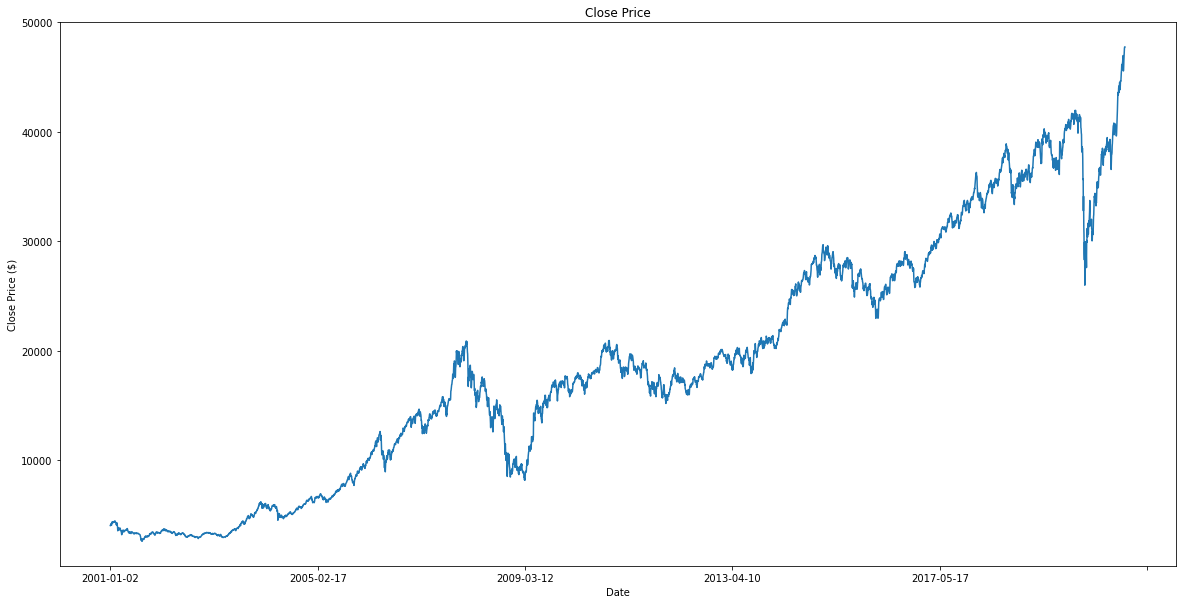

In [15]:
# setting figure size
plt.figure(figsize=(20,10))

# plotting close price
stock_data['Close'].plot()

# setting plot title, x and y labels
plt.title("Close Price")
plt.xlabel('Date')
plt.ylabel('Close Price ($)')

# 7. Data Preparation 

In [16]:
# calculating data_to_use
percentage_of_data = 1.0
data_to_use = int(percentage_of_data*(len(stock_data)-1))

# using 90% of data for training
train_end = int(data_to_use*0.9)
total_data = len(stock_data)
start = total_data - data_to_use

# printing number of records in the training and test datasets
print("Number of records in Training Data:", train_end)
print("Number of records in Test Data:", total_data - train_end)

Number of records in Training Data: 4402
Number of records in Test Data: 491


In [17]:
stock_data.head(1)

Close         Open  ...  positive  subjectivity
Date                                  ...                        
2001-01-02  4018.879883  3953.219971  ...     0.064      0.240909

[1 rows x 10 columns]

In [18]:
# predicting one step ahead
steps_to_predict = 1

# capturing data to be used for each column
close_price = stock_data.iloc[start:total_data,0] #close
open_price = stock_data.iloc[start:total_data,1] #open
high = stock_data.iloc[start:total_data,2] #high
low = stock_data.iloc[start:total_data,3] #low
volume = stock_data.iloc[start:total_data,4] #volume
compound = stock_data.iloc[start:total_data,5] #compound
negative = stock_data.iloc[start:total_data,6] #neg
neutral = stock_data.iloc[start:total_data,7] #neu
positive = stock_data.iloc[start:total_data,8] #pos
subjectivity = stock_data.iloc[start:total_data,9] #sub

# printing close price
print("Close Price:")
close_price

Close Price:


Date
2001-01-03     4060.020020
2001-01-04     4115.370117
2001-01-05     4183.729980
2001-01-08     4120.430176
2001-01-09     4125.310059
                  ...     
2020-12-24    46973.539063
2020-12-28    47353.750000
2020-12-29    47613.078125
2020-12-30    47746.218750
2020-12-31    47751.328125
Name: Close, Length: 4892, dtype: float64

In [19]:
stock_data.head(1)

Close         Open  ...  positive  subjectivity
Date                                  ...                        
2001-01-02  4018.879883  3953.219971  ...     0.064      0.240909

[1 rows x 10 columns]

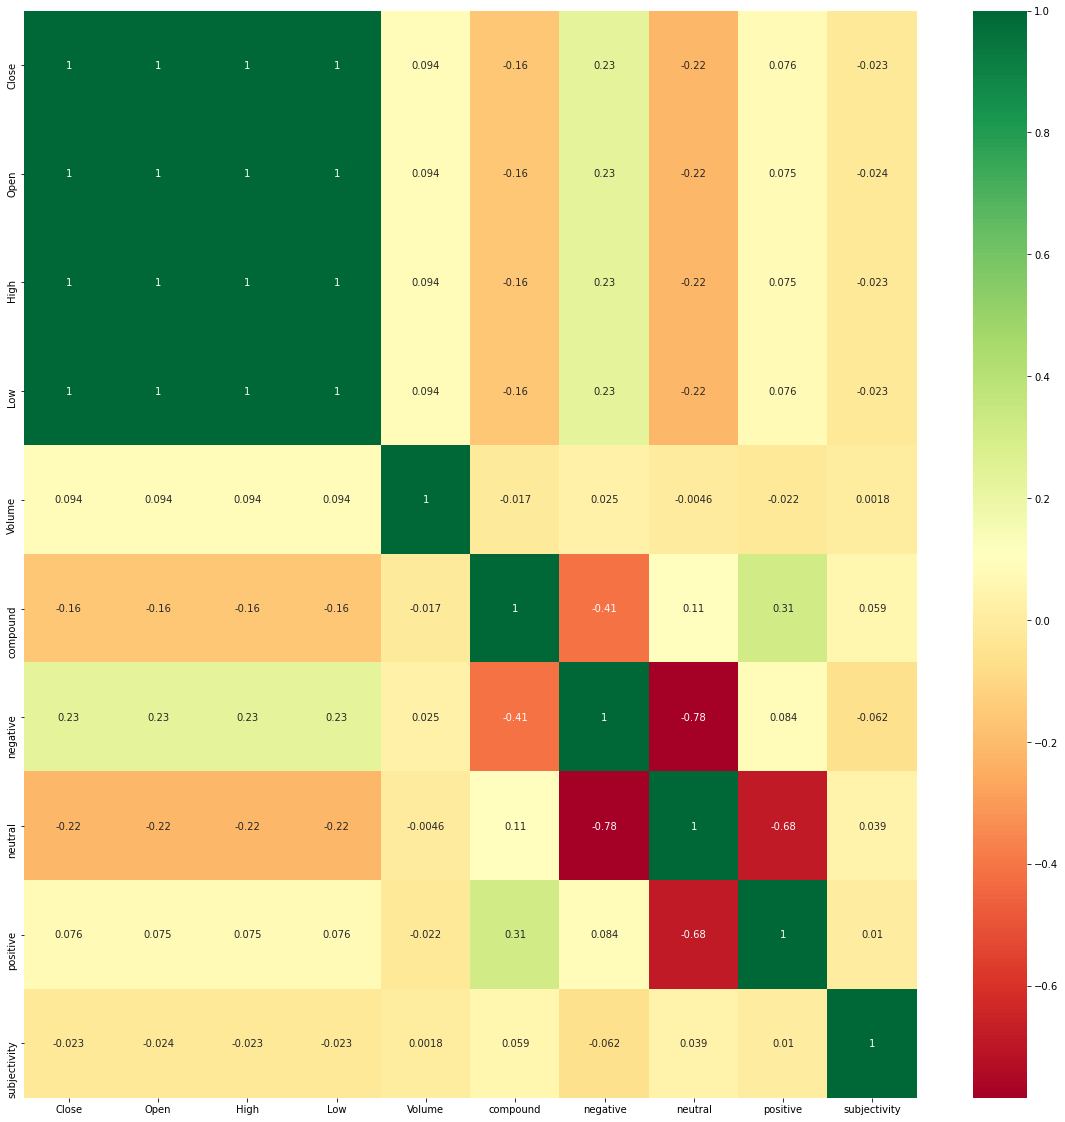

In [20]:
import seaborn as sns
#get correlations of each features in dataset
corrmat = stock_data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(stock_data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [22]:
# # shifting next day close
close_price_shifted = close_price.shift(-1) 

# shifting next day compound
compound_shifted = compound.shift(-1) 

# concatenating the captured training data into a dataframe
data = pd.concat([close_price,close_price_shifted, open_price,	high,	low,	volume,	compound,	negative,	neutral,	positive,	subjectivity], axis=1)

# setting column names of the revised stock data
data.columns = ['Close','close_price_shifted','Open',	'High',	'Low',	'Volume',	'compound',	'negative',	'neutral'	,'positive',	'subjectivity']

# dropping nulls
data = data.dropna()    
data.head(10)

Close  close_price_shifted  ...  positive  subjectivity
Date                                          ...                        
2001-01-03  4060.020020          4115.370117  ...     0.098      0.458333
2001-01-04  4115.370117          4183.729980  ...     0.080      0.508531
2001-01-05  4183.729980          4120.430176  ...     0.149      0.462652
2001-01-08  4120.430176          4125.310059  ...     0.026      0.316351
2001-01-09  4125.310059          4047.639893  ...     0.056      0.525926
2001-01-10  4047.639893          4296.689941  ...     0.000      0.000000
2001-01-23  4296.689941          4326.419922  ...     0.090      0.325859
2001-01-24  4326.419922          4330.220215  ...     0.040      0.244444
2001-01-25  4330.220215          4234.569824  ...     0.071      0.438522
2001-01-29  4234.569824          4372.040039  ...     0.129      0.267431

[10 rows x 11 columns]

# 7.1. Setting Target Variable And Feature Dataset

In [23]:
# setting the target variable as the shifted close_price
y = data['close_price_shifted']
y

Date
2001-01-03     4115.370117
2001-01-04     4183.729980
2001-01-05     4120.430176
2001-01-08     4125.310059
2001-01-09     4047.639893
                  ...     
2020-12-23    46973.539063
2020-12-24    47353.750000
2020-12-28    47613.078125
2020-12-29    47746.218750
2020-12-30    47751.328125
Name: close_price_shifted, Length: 4891, dtype: float64

In [24]:
# setting the features dataset for prediction  
cols = ['Close','Open',	'High',	'Low']
x = data[cols]
x

Close          Open          High           Low
Date                                                              
2001-01-03   4060.020020   3977.580078   4067.659912   3977.580078
2001-01-04   4115.370117   4180.970215   4180.970215   4109.549805
2001-01-05   4183.729980   4116.339844   4195.009766   4115.350098
2001-01-08   4120.430176   4164.759766   4206.720215   4101.529785
2001-01-09   4125.310059   4114.740234   4166.839844   4101.009766
...                  ...           ...           ...           ...
2020-12-23  46444.179688  46072.300781  46513.320313  45899.101563
2020-12-24  46973.539063  46743.488281  47053.398438  46539.019531
2020-12-28  47353.750000  47153.589844  47406.718750  47148.238281
2020-12-29  47613.078125  47466.621094  47714.550781  47361.898438
2020-12-30  47746.218750  47789.031250  47807.851563  47358.359375

[4891 rows x 4 columns]

# 7.3. Scaling the Target Variable and the Feature Dataset
Since we are using LSTM to predict stock prices, which is a time series data, it is important to understand that LSTM can be very sensitive to the scale of the data. Right now, if the data is observed, it is present in different scales. Therefore, it is important to re-scale the data so that the range of the dataset is same, for almost all records. Here a feature range of (-1,1) is used.

In [25]:
# scaling the feature dataset
scaler_x = preprocessing.MinMaxScaler (feature_range=(-1, 1))
x = np.array(x).reshape((len(x) ,len(cols)))
x = scaler_x.fit_transform(x)

# scaling the target variable
scaler_y = preprocessing.MinMaxScaler (feature_range=(-1, 1))
y = np.array (y).reshape ((len( y), 1))
y = scaler_y.fit_transform (y)

# displaying the scaled feature dataset and the target variable
x, y

(array([[-0.93532553, -0.93997007, -0.93861222, -0.93822641],
        [-0.93287349, -0.93096396, -0.93359019, -0.93233057],
        [-0.92984511, -0.93382579, -0.93296794, -0.93207144],
        ...,
        [ 0.98261339,  0.97186267,  0.98222136,  0.99045457],
        [ 0.99410179,  0.98572369,  0.99586481,  1.        ],
        [ 1.        ,  1.        ,  1.        ,  0.99984189]]),
 array([[-0.93288109],
        [-0.92985305],
        [-0.93265695],
        ...,
        [ 0.99387613],
        [ 0.99977368],
        [ 1.        ]]))

# 7.4. Dividing the dataset into Training and Test
Normally for any other dataset train_test_split from sklearn package is used, but for time series data like stock prices which is dependent on date, the dataset is divided into train and test dataset in a different way as shown below. In timeseries data, an observation for a particular date is always dependent on the previous date records.

In [26]:
# preparing training and test dataset
X_train = x[0 : train_end,]
X_test = x[train_end+1 : len(x),]    
y_train = y[0 : train_end] 
y_test = y[train_end+1 : len(y)]  

# printing the shape of the training and the test datasets
print('Number of rows and columns in the Training set X:', X_train.shape, 'and y:', y_train.shape)
print('Number of rows and columns in the Test set X:', X_test.shape, 'and y:', y_test.shape)

Number of rows and columns in the Training set X: (4402, 4) and y: (4402, 1)
Number of rows and columns in the Test set X: (488, 4) and y: (488, 1)


In [27]:
# reshaping the feature dataset for feeding into the model
X_train = X_train.reshape (X_train.shape + (1,)) 
X_test = X_test.reshape(X_test.shape + (1,))

# printing the re-shaped feature dataset
print('Shape of Training set X:', X_train.shape)
print('Shape of Test set X:', X_test.shape)

Shape of Training set X: (4402, 4, 1)
Shape of Test set X: (488, 4, 1)



# 9. Stock Data Modelling

In [28]:
# setting the seed to achieve consistent and less random predictions at each execution
np.random.seed(2016)
tf.random.set_seed(2016)
# setting the model architecture
model=Sequential()
model.add(LSTM(64,return_sequences= True,activation='tanh',input_shape=(len(cols),1)))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(1))
# printing the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 4, 64)             16896     
_________________________________________________________________
dropout (Dropout)            (None, 4, 64)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 29,345
Trainable params: 29,345
Non-trainable params: 0
_________________________________________________________________


In [29]:
# compiling the model
model.compile(loss='mse' , optimizer='adam')

# fitting the model using the training dataset
hist = model.fit(X_train, y_train, validation_split=0.1, epochs=10, batch_size=19, verbose=1)

Epoch 1/10
209/209 [==============================] - 6s 10ms/step - loss: 0.0194 - val_loss: 0.0044
Epoch 2/10
209/209 [==============================] - 1s 7ms/step - loss: 0.0037 - val_loss: 4.4994e-04
Epoch 3/10
209/209 [==============================] - 1s 7ms/step - loss: 0.0033 - val_loss: 0.0011
Epoch 4/10
209/209 [==============================] - 1s 7ms/step - loss: 0.0031 - val_loss: 7.7503e-04
Epoch 5/10
209/209 [==============================] - 1s 6ms/step - loss: 0.0028 - val_loss: 7.6986e-04
Epoch 6/10
209/209 [==============================] - 1s 6ms/step - loss: 0.0027 - val_loss: 2.2252e-04
Epoch 7/10
209/209 [==============================] - 1s 7ms/step - loss: 0.0025 - val_loss: 6.4309e-04
Epoch 8/10
209/209 [==============================] - 1s 7ms/step - loss: 0.0024 - val_loss: 2.9867e-04
Epoch 9/10
209/209 [==============================] - 1s 7ms/step - loss: 0.0023 - val_loss: 8.0936e-04
Epoch 10/10
209/209 [==============================] - 1s 7ms/step - lo

# 9.1. Saving the Model to disk

In [ ]:
# saving the model as a json file
model_json = model.to_json()
with open('model.json', 'w') as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights('model.h5')
print('Model is saved to the disk')

Model is saved to the disk


# 10. Model Predictions

In [30]:
# performing predictions
predictions = model.predict(X_test) 

# unscaling the predictions
predictions = scaler_y.inverse_transform(np.array(predictions).reshape((len(predictions), 1)))

# printing the predictions
print('Predictions:')
predictions[0:5]

Predictions:


array([[34705.07 ],
       [34616.6  ],
       [34870.195],
       [34897.438],
       [35078.35 ]], dtype=float32)

# 11. Model Evaluation

In [ ]:
# calculating the training mean-squared-error
train_loss = model.evaluate(X_train, y_train, batch_size = 1)

# calculating the test mean-squared-error
test_loss = model.evaluate(X_test, y_test, batch_size = 1)

# printing the training and the test mean-squared-errors
print('Train Loss =', round(train_loss,4))
print('Test Loss =', round(test_loss,4))

489/489 [==============================] - 1s 2ms/step - loss: 0.0032
Train Loss = 0.0001
Test Loss = 0.0032


# 12. Plotting the Predictions against unseen data

In [31]:
# unscaling the test feature dataset, x_test
X_test = scaler_x.inverse_transform(np.array(X_test).reshape((len(X_test), len(cols))))

# unscaling the test y dataset, y_test
y_train = scaler_y.inverse_transform(np.array(y_train).reshape((len(y_train), 1)))
y_test = scaler_y.inverse_transform(np.array(y_test).reshape((len(y_test), 1)))

In [32]:
# calculating root mean squared error
root_mean_square_error = np.sqrt(np.mean(np.power((y_test - predictions),2)))
print('Root Mean Square Error =', round(root_mean_square_error,4))

Root Mean Square Error = 1632.4271


In [ ]:
# calculating root mean squared error using sklearn.metrics package
rmse = metrics.mean_squared_error(y_test, predictions)
print('Root Mean Square Error (sklearn.metrics) =', round(np.sqrt(rmse),4))

Root Mean Square Error (sklearn.metrics) = 1281.891


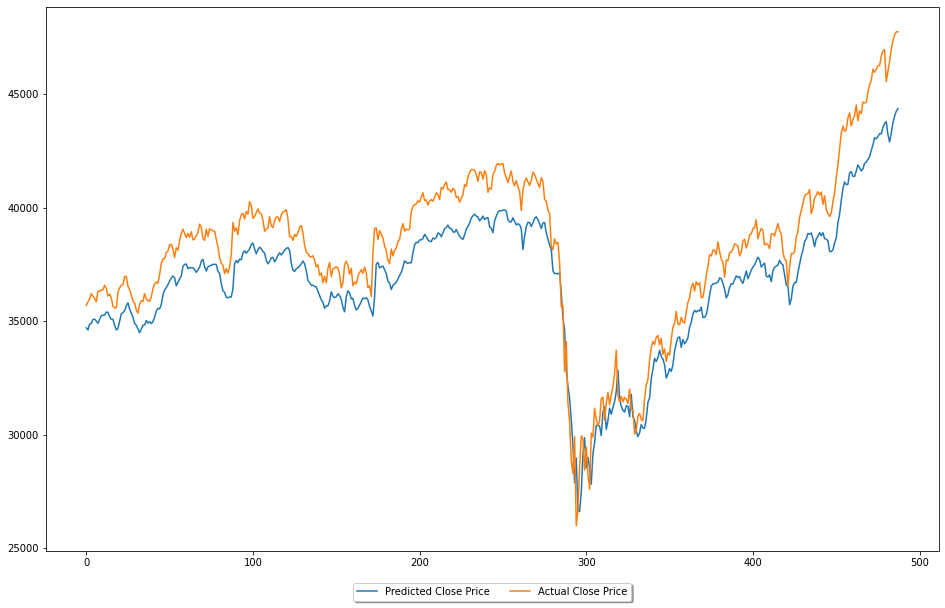

In [62]:
# plotting
plt.figure(figsize=(16,10))

# plt.plot([row[0] for row in y_train], label="Training Close Price")
plt.plot(predictions, label="Predicted Close Price")
plt.plot([row[0] for row in y_test], label="Actual Close Price")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)
plt.show()

In [34]:
df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': predictions.flatten()})
df

Actual     Predicted
0    35695.101563  34705.070312
1    35850.160156  34616.601562
2    35980.929688  34870.195312
3    36212.910156  34897.437500
4    36106.500000  35078.351562
..            ...           ...
483  46973.539063  43284.406250
484  47353.750000  43727.335938
485  47613.078125  44034.628906
486  47746.218750  44243.730469
487  47751.328125  44366.562500

[488 rows x 2 columns]

In [48]:
# setting the features dataset for prediction  
cols = ['negative','Open' ,'High', 'Low', 'Close']
x2 = data[cols]
x2

negative          Open          High           Low         Close
Date                                                                        
2001-01-03     0.084   3977.580078   4067.659912   3977.580078   4060.020020
2001-01-04     0.077   4180.970215   4180.970215   4109.549805   4115.370117
2001-01-05     0.105   4116.339844   4195.009766   4115.350098   4183.729980
2001-01-08     0.119   4164.759766   4206.720215   4101.529785   4120.430176
2001-01-09     0.121   4114.740234   4166.839844   4101.009766   4125.310059
...              ...           ...           ...           ...           ...
2020-12-23     0.119  46072.300781  46513.320313  45899.101563  46444.179688
2020-12-24     0.082  46743.488281  47053.398438  46539.019531  46973.539063
2020-12-28     0.127  47153.589844  47406.718750  47148.238281  47353.750000
2020-12-29     0.136  47466.621094  47714.550781  47361.898438  47613.078125
2020-12-30     0.124  47789.031250  47807.851563  47358.359375  47746.218750

[4891 rows x 5 columns]

In [50]:
# setting the target variable as the shifted close_price
y2 = data['close_price_shifted']
y2

Date
2001-01-03     4115.370117
2001-01-04     4183.729980
2001-01-05     4120.430176
2001-01-08     4125.310059
2001-01-09     4047.639893
                  ...     
2020-12-23    46973.539063
2020-12-24    47353.750000
2020-12-28    47613.078125
2020-12-29    47746.218750
2020-12-30    47751.328125
Name: close_price_shifted, Length: 4891, dtype: float64

In [51]:
# scaling the feature dataset
scaler_x2 = preprocessing.MinMaxScaler (feature_range=(-1, 1))
x2 = np.array(x2).reshape((len(x2) ,len(cols)))
x2 = scaler_x2.fit_transform(x2)

# scaling the target variable
scaler_y2 = preprocessing.MinMaxScaler (feature_range=(-1, 1))
y2 = np.array (y2).reshape ((len( y2), 1))
y2 = scaler_y2.fit_transform (y2)

# displaying the scaled feature dataset and the target variable
x2, y2

(array([[-0.62162162, -0.93997007, -0.93861222, -0.93822641, -0.93532553],
        [-0.65315315, -0.93096396, -0.93359019, -0.93233057, -0.93287349],
        [-0.52702703, -0.93382579, -0.93296794, -0.93207144, -0.92984511],
        ...,
        [-0.42792793,  0.97186267,  0.98222136,  0.99045457,  0.98261339],
        [-0.38738739,  0.98572369,  0.99586481,  1.        ,  0.99410179],
        [-0.44144144,  1.        ,  1.        ,  0.99984189,  1.        ]]),
 array([[-0.93288109],
        [-0.92985305],
        [-0.93265695],
        ...,
        [ 0.99387613],
        [ 0.99977368],
        [ 1.        ]]))

In [52]:
# preparing training and test dataset
X_train2 = x2[0 : train_end,]
X_test2 = x2[train_end+1 : len(x2),]    
y_train2 = y2[0 : train_end] 
y_test2 = y2[train_end+1 : len(y2)]  

# printing the shape of the training and the test datasets
print('Number of rows and columns in the Training set X:', X_train2.shape, 'and y:', y_train2.shape)
print('Number of rows and columns in the Test set X:', X_test2.shape, 'and y:', y_test2.shape)

Number of rows and columns in the Training set X: (4402, 5) and y: (4402, 1)
Number of rows and columns in the Test set X: (488, 5) and y: (488, 1)


In [53]:
# reshaping the feature dataset for feeding into the model
X_train2 = X_train2.reshape (X_train2.shape + (1,)) 
X_test2 = X_test2.reshape(X_test2.shape + (1,))

# printing the re-shaped feature dataset
print('Shape of Training set X:', X_train2.shape)
print('Shape of Test set X:', X_test2.shape)

Shape of Training set X: (4402, 5, 1)
Shape of Test set X: (488, 5, 1)


In [54]:
np.random.seed(2016)
tf.random.set_seed(2016)
model=Sequential()
model.add(LSTM(100,return_sequences=True,activation='tanh',input_shape=(X_train2.shape[1],1)))
model.add(Dropout(0.1))
model.add(LSTM(100,return_sequences=True,activation='tanh'))
model.add(Dropout(0.1))
model.add(LSTM(100,activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(1))

In [55]:
# compiling the model
model.compile(loss='mse' , optimizer='adam')

# fitting the model using the training dataset
hist = model.fit(X_train2, y_train2, validation_split=0.1, epochs=6, batch_size=8)

Epoch 1/6
496/496 [==============================] - 13s 17ms/step - loss: 0.0108 - val_loss: 2.8961e-04
Epoch 2/6
496/496 [==============================] - 7s 14ms/step - loss: 0.0014 - val_loss: 1.8362e-04
Epoch 3/6
496/496 [==============================] - 7s 14ms/step - loss: 0.0011 - val_loss: 2.9308e-04
Epoch 4/6
496/496 [==============================] - 7s 14ms/step - loss: 0.0010 - val_loss: 1.6615e-04
Epoch 5/6
496/496 [==============================] - 7s 14ms/step - loss: 8.7322e-04 - val_loss: 5.6459e-04
Epoch 6/6
496/496 [==============================] - 7s 14ms/step - loss: 8.3758e-04 - val_loss: 4.6040e-04


In [56]:
# performing predictions
predictions2 = model.predict(X_test2) 

# unscaling the predictions
predictions2 = scaler_y2.inverse_transform(np.array(predictions2).reshape((len(predictions2), 1)))

# printing the predictions
print('Predictions:')
predictions2[0:5]

Predictions:


array([[35138.188],
       [35101.914],
       [35532.934],
       [35399.742],
       [35625.293]], dtype=float32)

In [43]:
# calculating the training mean-squared-error
train_loss2 = model.evaluate(X_train2, y_train2, batch_size = 1)

# calculating the test mean-squared-error
test_loss2 = model.evaluate(X_test2, y_test2, batch_size = 1)

# printing the training and the test mean-squared-errors
print('Train Loss =', round(train_loss2,4))
print('Test Loss =', round(test_loss2,4))

488/488 [==============================] - 1s 2ms/step - loss: 0.0011
Train Loss = 0.0001
Test Loss = 0.0011


In [57]:
# unscaling the test feature dataset, x_test
X_test2 = scaler_x2.inverse_transform(np.array(X_test2).reshape((len(X_test2), len(cols))))

# unscaling the test y dataset, y_test
y_train2 = scaler_y2.inverse_transform(np.array(y_train2).reshape((len(y_train2), 1)))
y_test2 = scaler_y2.inverse_transform(np.array(y_test2).reshape((len(y_test2), 1)))

In [58]:
# calculating root mean squared error
root_mean_square_error = np.sqrt(np.mean(np.power((y_test2 - predictions2),2)))
print('Root Mean Square Error =', round(root_mean_square_error,4))

Root Mean Square Error = 1055.6508


In [ ]:
# calculating root mean squared error using sklearn.metrics package
rmse = metrics.mean_squared_error(y_test2, predictions2)
print('Root Mean Square Error (sklearn.metrics) =', round(np.sqrt(rmse),4))

Root Mean Square Error (sklearn.metrics) = 753.0666


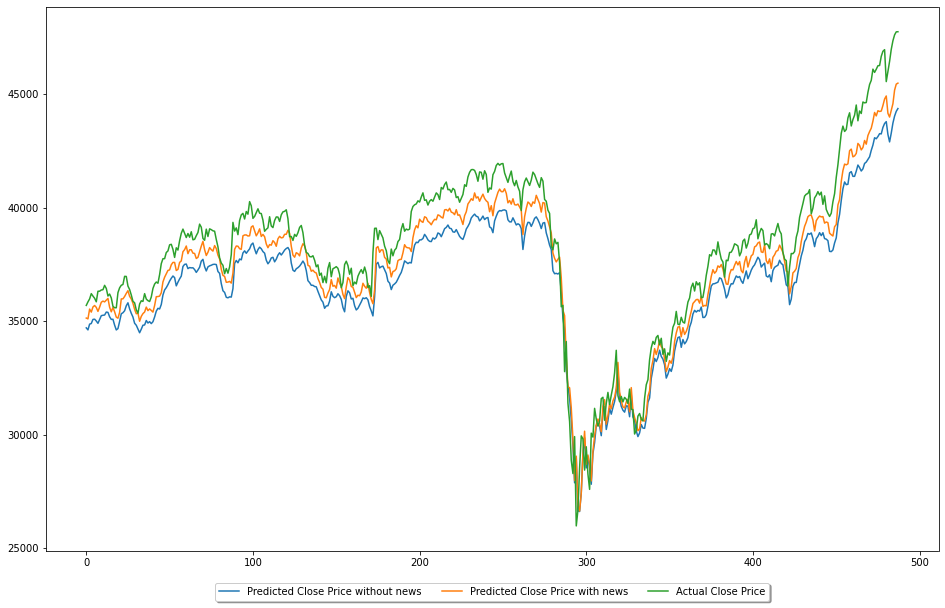

In [61]:
# plotting
plt.figure(figsize=(16,10))

# plt.plot([row[0] for row in y_train], label="Training Close Price")
plt.plot(predictions, label="Predicted Close Price without news")
plt.plot(predictions2, label="Predicted Close Price with news")
plt.plot([row[0] for row in y_test2], label="Actual Close Price")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=4)
plt.show()

In [60]:
df = pd.DataFrame({'Actual': y_test2.flatten(), 'Predicted': predictions2.flatten()})
df

Actual     Predicted
0    35695.101563  35138.187500
1    35850.160156  35101.914062
2    35980.929688  35532.933594
3    36212.910156  35399.742188
4    36106.500000  35625.292969
..            ...           ...
483  46973.539063  44285.843750
484  47353.750000  44580.460938
485  47613.078125  45178.910156
486  47746.218750  45442.582031
487  47751.328125  45486.539062

[488 rows x 2 columns]